# TOC

__Chapter 3 - CNN and RNN using PyTorch__

1. [Import](#Import)
1. [Recipe 3-1 : Setting up a loss function](#Recipe-3-1-:-Setting-up-a-loss-function)
1. [Recipe 3-2 : Estimating the derivative of the loss function](#Recipe-3-2-:-Estimating-the-derivative-of-the-loss-function)
1. [Recipe 3-3 : Fine-tuning a model](#Recipe-3-3-:-Fine-tuning-a-model)
1. [Recipe 3-4 : Selecting an optimization function](#Recipe-3-4-:-Selecting-an-optimization-function)
1. [Recipe 3-5 : Further optimizing the function](#Recipe-3-5-:-Further-optimizing-the-function)
1. [Recipe 3-6 : Implementing a convolutional neural network](#Recipe-3-6-:-Implementing-a-convolutional-neural-network)
1. [Recipe 3-7 : Reloading a model](#Recipe-3-7-:-Reloading-a-model)
1. [Recipe 3-8 : Implementing a convolutional neural network](#Recipe-3-8-:-Implementing-a-convolutional-neural-network)
1. [Recipe 3-9 : Implementing a RNN for regression problems](#Recipe-3-9-:-Implementing-a-RNN-for-regression-problems)
1. [Recipe 3-10 : Working with autoencoders](#Recipe-3-10-:-Working-with-autoencoders)
1. [Recipe 3-11 : Restricting model overfitting](#Recipe-3-11-:-Restricting-model-overfitting)
1. [Recipe 3-12 : Initializing weights in the dropout rate](#Recipe-3-12-:-Initializing-weights-in-the-dropout-rate)
1. [Recipe 3-13 : Embedding layers in RNN](#Recipe-3-13-:-Embedding-layers-in-RNN)


# Import

<a id = 'Import'></a>

In [1]:
# standard libary and settings
import os
import sys
import importlib
import itertools
import warnings

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.options.display.float_format = "{:,.6f}".format

import torch

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

# magic functions
%matplotlib inline

# Recipe 3-1 : Setting up a loss function

__Problem__: How do we set up a loss function and optimize it?

__Solution__: We define a model and a loss function and use gradient descent to minimize the error

<a id = 'Recipe-3-1-:-Setting-up-a-loss-function'></a>

In [26]:
# create two two tensors
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])

# define the model. the weight parameter w will be multiplied by the t_u tensor. the result is added
# with a constant tensor b, and the loss function utilized it custom build, but is also implemented in
# PyTorch. t_u is the tensor of the input data. t_p is the tensor predicted. t_c contains the true
# values, which the predicted tensor needs to be compare to in order to calculate the loss function
def model(t_u, w, b):
    return w * t_u + b


def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c) ** 2
    return squared_diffs.mean()


w = torch.ones(1)
b = torch.zeros(1)

t_p = model(t_u, w, b)

loss = loss_fn(t_p, t_c)
loss

tensor(1763.8846)

In [27]:
# the initial loss value is high due to the initial weights chosen. the error in this first iteration
# is backpropagated to reduce the errors in the second round, and the weights and bias are updated.
delta = 0.1
loss_rate_of_change_w = (
    loss_fn(model(t_u, w + delta, b), t_c) - loss_fn(model(t_u, w - delta, b), t_c)
) / (2.0 * delta)

learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w

loss_rate_of_change_b = (
    loss_fn(model(t_u, w, b + delta), t_c) - loss_fn(model(t_u, w, b - delta), t_c)
) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b
b

tensor([46.0250])

In [30]:
# the above example is a simple mean square loss function operating in a two-dimensional space, using
# a small tensor. The following example shows a PyTorch implementation using the MSELoss function in
# the PyTorch neural network module
from torch import nn

loss = nn.MSELoss()
inputTensor = torch.randn(10, 5, requires_grad=True)
target = torch.randn(10, 5)
output = loss(inputTensor, target)
output.backward()
output

tensor(2.0959, grad_fn=<MseLossBackward>)

In [31]:
# inspect gradient calculation associated with the output variable
output.grad_fn

# Recipe 3-2 : Estimating the derivative of the loss function

__Problem__: How do we estimate the derivative of a loss function?

__Solution__: In this example, the loss function is two times the differences between the input and output tensors rather than the MSELoss function. The following grad_fn is a custom function that will help illustrate how the final output retrieves the derivative of the loss function

<a id = 'Recipe-3-2-:-Estimating-the-derivative-of-the-loss-function'></a>

In [45]:
# The previous recipe shows that the grad_fn is an embedded object in the output object tensor.
# This recipe illustrates how this is computed. grad_fn is a derivative of the loss function
# with respect to the parameters of the model
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c)
    return dsq_diffs


def model(t_u, w, b):
    return w * t_u + b


def dmodel_dw(t_u, w, b):
    return t_u


def dmodel_db(t_u, w, b):
    return 1.0


def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dw = dloss_fn(t_p, t_c) * dmodel_dw(t_u, w, b)
    dloss_db = dloss_fn(t_p, t_c) * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.mean(), dloss_db.mean()])


t_un = 0.1 * t_u

params = torch.tensor([1.0, 0.0])
epochs = 10000
learning_Rate = 1e-2
for epoch in range(epochs):
    # forward pass
    w, b = params
    t_p = model(t_un, w, b)

    loss = loss_fn(t_p, t_c)

    # backward pass
    grad = grad_fn(t_un, t_c, t_p, w, b)
    if epoch % 1000 == 0:
        print("Epoch {}, loss {}".format(epoch, float(loss)))
        print("Params: {}".format(params))
        print("Grad: {}\n".format(grad))

    params = params - learning_rate * grad

params

Epoch 0, loss 80.36434173583984
Params: tensor([1., 0.])
Grad: tensor([-77.6140, -10.6400])

Epoch 1000, loss 3.825483560562134
Params: tensor([  4.8021, -14.1031])
Grad: tensor([-0.0961,  0.5439])

Epoch 2000, loss 2.9575958251953125
Params: tensor([  5.2644, -16.7200])
Grad: tensor([-0.0176,  0.0993])

Epoch 3000, loss 2.9286458492279053
Params: tensor([  5.3489, -17.1980])
Grad: tensor([-0.0032,  0.0181])

Epoch 4000, loss 2.927680015563965
Params: tensor([  5.3643, -17.2853])
Grad: tensor([-0.0006,  0.0033])

Epoch 5000, loss 2.9276466369628906
Params: tensor([  5.3671, -17.3012])
Grad: tensor([-0.0001,  0.0006])

Epoch 6000, loss 2.927647352218628
Params: tensor([  5.3676, -17.3042])
Grad: tensor([-3.7627e-05,  9.7448e-05])

Epoch 7000, loss 2.927645206451416
Params: tensor([  5.3676, -17.3042])
Grad: tensor([-1.9940e-05,  9.4327e-05])

Epoch 8000, loss 2.927645206451416
Params: tensor([  5.3676, -17.3042])
Grad: tensor([-1.9940e-05,  9.4327e-05])

Epoch 9000, loss 2.9276452064514

tensor([  5.3676, -17.3042])

In [53]:
# redefine the model and the loss function and apply it to the same example, but set params so that it requires_grad = True
def model(t_u, w, b):
    return w * t_u + b


def loss_fn(t_p, t_c):
    sq_diffs = (t_p - t_c) ** 2
    return sq_diffs.mean()


params = torch.tensor([1.0, 0.0], requires_grad=True)
loss = loss_fn(model(t_u, *params), t_c)

# reset the grad function because otherwise the error values accumulated will continue to the next session
params.grad is None

True

# Recipe 3-3 : Fine-tuning a model

__Problem__: How do we find the gradients of the loss function by applying an optimization funciton to optimize the loss function?

__Solution__: Use the backward() function

<a id = 'Recipe-3-3-:-Fine-tuning-a-model'></a>

In [54]:
# the backward() function calculates the gradients of a function with respect to its parameters
loss.backward()
params.grad

tensor([4517.2969,   82.6000])

In [57]:
# zero out gradients for subseqeunt calculations
if params.grad is not None:
    params.grad.zero_()


def model(t_u, w, b):
    return t_u * w + b


def loss_fn(t_p, t_c):
    sq_diffs = (t_p - t_c) ** 2
    return sq_diffs.mean()


params = torch.tensor([1.0, 0.0], requires_grad=True)
epochs = 5000
learning_rate = 1e-2

t_un = 0.1 * t_u

for epoch in range(epochs):
    t_p = model(t_un, *params)
    loss = loss_fn(t_p, t_c)

    # backward pass
    if params.grad is not None:
        params.grad.zero_()

    if epoch % 1000 == 0:
        print("Epoch {}, loss {}".format(epoch, float(loss)))
        print("Params: {}".format(params))

    loss.backward()

    params = (params - learning_rate * params.grad).detach().requires_grad_()

params

Epoch 0, loss 80.36434173583984
Params: tensor([1., 0.], requires_grad=True)
Epoch 1000, loss 3.825483560562134
Params: tensor([  4.8021, -14.1031], requires_grad=True)
Epoch 2000, loss 2.9575958251953125
Params: tensor([  5.2644, -16.7200], requires_grad=True)
Epoch 3000, loss 2.9286458492279053
Params: tensor([  5.3489, -17.1980], requires_grad=True)
Epoch 4000, loss 2.9276793003082275
Params: tensor([  5.3643, -17.2853], requires_grad=True)


tensor([  5.3671, -17.3012], requires_grad=True)

# Recipe 3-4 : Selecting an optimization function

__Problem__: How do we optimize the gradients with the function in Recipe 3-3?

__Solution__: There are certain functions embedded into PyTorch, and others need to be created by the user

<a id = 'Recipe-3-4-:-Selecting-an-optimization-function'></a>

In [58]:
# print the optimizers available
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'lr_scheduler']

In [59]:
# optimize the weights using SGD
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()
optimizer.step()

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

In [60]:
# implement optimization using SGD
def model(t_u, w, b):
    return t_u * w + b


def loss_fn(t_p, t_c):
    sq_diffs = (t_p - t_c) ** 2
    return sq_diffs.mean()


params = torch.tensor([1.0, 0.0], requires_grad=True)
epochs = 5000
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_un = 0.1 * t_u

for epoch in range(epochs):
    # forward pass
    t_p = model(t_un, *params)
    loss = loss_fn(t_p, t_c)

    if epoch % 1000 == 0:
        print("Epoch {}, loss {}".format(epoch, float(loss)))
        print("Params: {}".format(params))

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
t_p = model(t_un, *params)

params

Epoch 0, loss 80.36434173583984
Params: tensor([1., 0.], requires_grad=True)
Epoch 1000, loss 3.825483560562134
Params: tensor([  4.8021, -14.1031], requires_grad=True)
Epoch 2000, loss 2.9575958251953125
Params: tensor([  5.2644, -16.7200], requires_grad=True)
Epoch 3000, loss 2.9286458492279053
Params: tensor([  5.3489, -17.1980], requires_grad=True)
Epoch 4000, loss 2.9276793003082275
Params: tensor([  5.3643, -17.2853], requires_grad=True)


tensor([  5.3671, -17.3012], requires_grad=True)

In [62]:
# implement optimization using Adam
def model(t_u, w, b):
    return t_u * w + b


def loss_fn(t_p, t_c):
    sq_diffs = (t_p - t_c) ** 2
    return sq_diffs.mean()


params = torch.tensor([1.0, 0.0], requires_grad=True)
epochs = 5000
learning_rate = 1e-2
optimizer = optim.Adam([params], lr=learning_rate)

for epoch in range(epochs):
    # forward pass
    t_p = model(t_u, *params)
    loss = loss_fn(t_p, t_c)

    if epoch % 1000 == 0:
        print("Epoch {}, loss {}".format(epoch, float(loss)))
        print("Params: {}".format(params))

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
t_p = model(t_u, *params)

params

Epoch 0, loss 1763.8846435546875
Params: tensor([1., 0.], requires_grad=True)
Epoch 1000, loss 22.952489852905273
Params: tensor([ 0.2700, -2.1840], requires_grad=True)
Epoch 2000, loss 16.018842697143555
Params: tensor([ 0.3211, -5.0789], requires_grad=True)
Epoch 3000, loss 9.326725959777832
Params: tensor([ 0.3860, -8.7571], requires_grad=True)
Epoch 4000, loss 4.993494987487793
Params: tensor([  0.4511, -12.4481], requires_grad=True)


tensor([  0.5017, -15.3177], requires_grad=True)

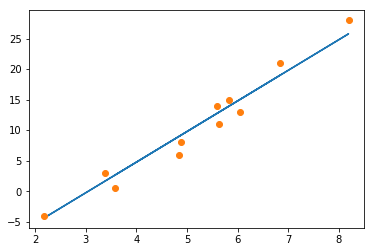

In [64]:
# graph the actual data and the predicted values
plt.plot(0.1 * t_u.numpy(), t_p.detach().numpy())
plt.plot(0.1 * t_u.numpy(), t_c.numpy(), "o")

# Recipe 3-5 : Further optimizing the function

__Problem__: How do we optimize the training set and tset it with a validation set using random samples?

__Solution__: Create a dataset and set aside 20% of the data as validation data. Randomly separate the data using randomly selected shuffled indices. We are most interested in the accuracy on the validation data.

<a id = 'Recipe-3-5-:-Further-optimizing-the-function'></a>

In [68]:
# create data and separate into train and validation sets
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

In [71]:
# implement using SGD
def model(t_u, w, b):
    return t_u * w + b


def loss_fn(t_p, t_c):
    sq_diffs = (t_p - t_c) ** 2
    return sq_diffs.mean()


params = torch.tensor([1.0, 0.0], requires_grad=True)
epochs = 5000
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

for epoch in range(epochs):
    # forward pass
    t_p_train = model(t_un_train, *params)
    loss_train = loss_fn(t_p_train, t_c_train)

    t_p_val = model(t_un_val, *params)
    loss_val = loss_fn(t_p_val, t_c_val)

    if epoch % 1000 == 0:
        print(
            "Epoch {}, training loss {}, validation loss {}".format(
                epoch, float(loss_train), float(loss_val)
            )
        )
        print("Params: {}".format(params))

    # backward pass
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
t_p = model(t_un, *params)

params

Epoch 0, training loss 88.7099838256836, validation loss 42.80900192260742
Params: tensor([1., 0.], requires_grad=True)
Epoch 1000, training loss 3.1420304775238037, validation loss 5.639771461486816
Params: tensor([  4.9205, -14.5964], requires_grad=True)
Epoch 2000, training loss 2.6248726844787598, validation loss 4.6835737228393555
Params: tensor([  5.2609, -16.5461], requires_grad=True)
Epoch 3000, training loss 2.615931987762451, validation loss 4.564709663391113
Params: tensor([  5.3056, -16.8024], requires_grad=True)
Epoch 4000, training loss 2.615778684616089, validation loss 4.549202919006348
Params: tensor([  5.3115, -16.8361], requires_grad=True)


tensor([  5.3123, -16.8405], requires_grad=True)

# Recipe 3-6 : Implementing a convolutional neural network

__Problem__: How do we implement a CNN using PyTorch

__Solution__: torchvision has many built-in datasets that we can use for testing a CNN model

<a id = 'Recipe-3-6-:-Implementing-a-convolutional-neural-network'></a>

torch.Size([60000, 28, 28])
torch.Size([60000])


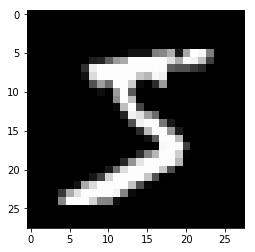

In [4]:
# setup CNN by loading dataset and visualize sample
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision

torch.manual_seed(1)

epoch = 1
batch_size = 50
lr = 0.001
download_mnist = True

train_data = torchvision.datasets.MNIST(
    root="C:\\Users\\petersont\\Desktop\\mnist",
    train=True
    # transform to shape of (color x height x width) and normalize to range [0.0, 1.0]
    ,
    transform=torchvision.transforms.ToTensor(),
    download=download_mnist,
)

# plot on example
print(train_data.data.size())
print(train_data.targets.size())
plt.imshow(train_data.data[0].numpy(), cmap="gray")

In [5]:
# load the dataset using the loader functionality. the image batch shape with be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# convert test data into Variable, pick 2000 sammples to speed up testing
test_data = torchvision.datasets.MNIST(
    root="C:\\Users\\petersont\\Desktop\\mnist", train=False
)
test_x = (
    Variable(torch.unsqueeze(test_data.data, dim=1)).type(torch.FloatTensor)[:2000]
    / 255
)

# shape from (2000, 28, 28) tp (2000, 1 , 28, 28) with values in range of (0,1)
test_y = test_data.targets[:2000]

# build CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(  # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,  # input height
                out_channels=16,  # n_filters
                kernel_size=5,  # filter size
                stride=1,  # filter step
                padding=2,
            ),  # output shape (16, 28, 28)
            nn.ReLU(),  # activation
            nn.MaxPool2d(
                kernel_size=2
            ),  # choose max value in 2x2 area, output shape (16, 14, 14)
        )

        self.conv2 = nn.Sequential(  # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),  # output shape (32, 14, 14)
            nn.ReLU(),  # activation
            nn.MaxPool2d(2),  # output shape (32, 7, 7)
        )

        self.out = nn.Linear(32 * 7 * 7, 10)  # fully connected layer, 10 output classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)

        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x  # return x for visualization


# create instance
cnn = CNN()
print(cnn)

# optimize all CNN parameters
optimizer = torch.optim.Adam(cnn.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


Step: 0 | train loss : 2.3104543685913086 | test accuracy: 0.0605


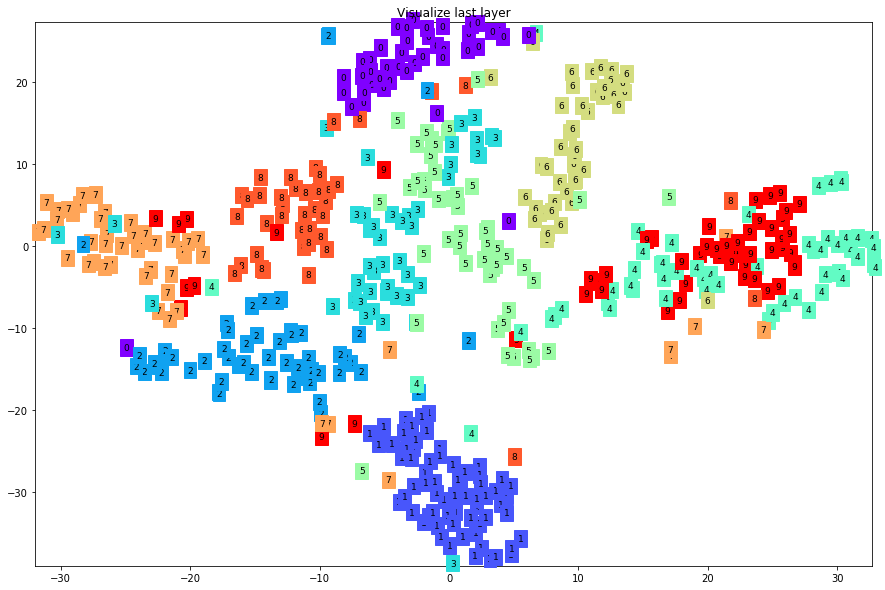

Step: 300 | train loss : 0.19453315436840057 | test accuracy: 0.946


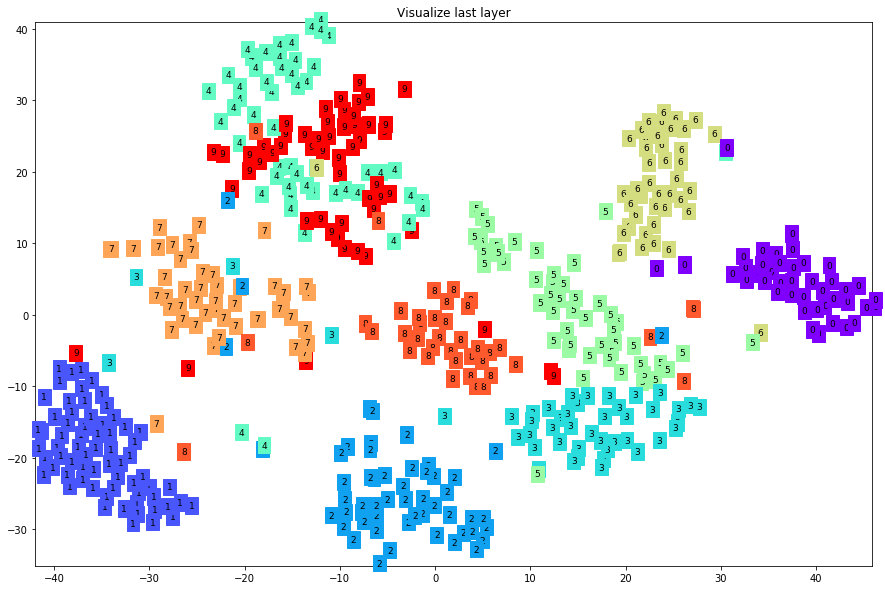

Step: 600 | train loss : 0.02393045835196972 | test accuracy: 0.9685


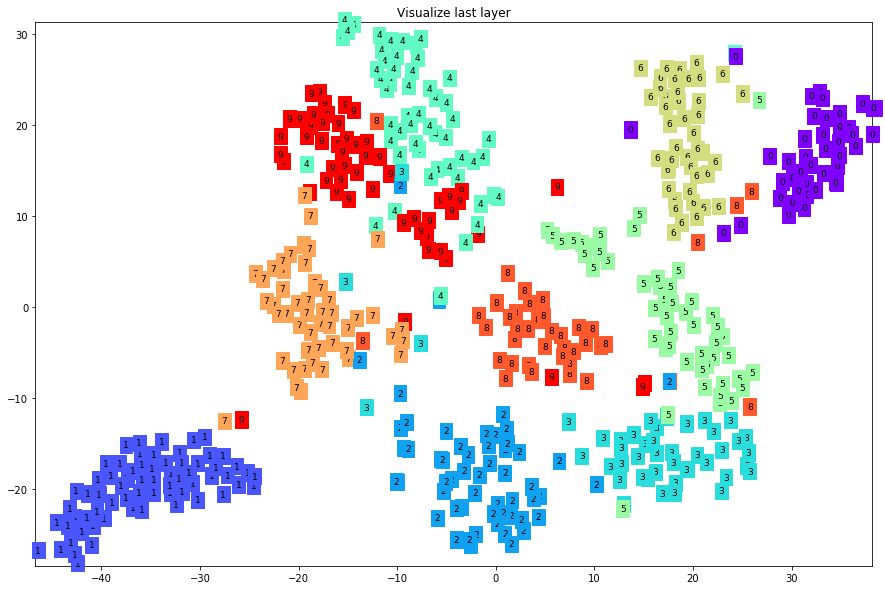

Step: 900 | train loss : 0.05513238534331322 | test accuracy: 0.978


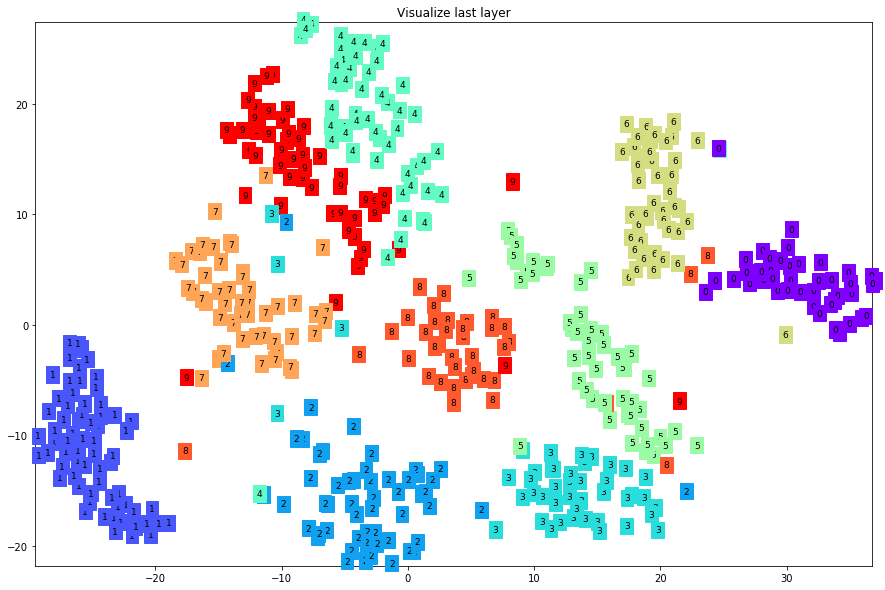

In [6]:
# use TSNE to visualize clustering of observations
from matplotlib import cm
from sklearn.manifold import TSNE


def plot_with_labels(lowDWeights, labels):
    fig = plt.figure(figsize=(15, 10))
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9))
        plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max())
    plt.ylim(Y.min(), Y.max())
    plt.title("Visualize last layer")
    plt.show()


# execute CNN
for epoch in range(epoch):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)
        b_y = Variable(y)

        output = cnn(b_x)[0]  # cnn output
        loss = loss_func(output, b_y)  # cross entropy loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, computes gradients
        optimizer.step()  # apply gradients

        if step % 300 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print(
                "Step: {} | train loss : {} | test accuracy: {}".format(
                    step, loss.data.item(), accuracy
                )
            )

            tsne = TSNE(perplexity=30, n_components=2, init="pca", n_iter=5000)
            plot_only = 500
            low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
            labels = test_y.numpy()[:plot_only]
            plot_with_labels(low_dim_embs, labels)
# plt.ioff()

In [7]:
# evaluate subset of predictions
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, "prediction number")
print(test_y[:10].numpy(), "real number")

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


# Recipe 3-7 : Reloading a model

__Problem__: How do we store and re-upload a model that has already been trained? How can we retrain the previously stored model with new inputs?

__Solution__: In production, we typically cannot train and predict at the same time because training takes a long time, and the predictions cannot be created until the training process is completed. The solution is to train the model and store it, then invoke the saved model to generate predictions as needed

<a id = 'Recipe-3-7-:-Reloading-a-model'></a>

In [16]:
# imports and sample data

from torch.autograd import Variable

torch.manual_seed(1)

# x is the independent variable, y is the depenedent variable
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # shape = (100, 1)
x = Variable(x, requires_grad=False)

y = x.pow(2) + 0.2 * torch.rand(x.size())  # noisy y data, shape = (100, 1)
y = Variable(y, requires_grad=False)

In [21]:
# the following save function stores the mode. the net1 object is the trained neural network, which can
# be stored using two different protocls: 1) save the entire model with all the weights and biases, or
# 2) save the model using only the weights. This decision point is generally based on the size of the
# model. bigger models may best be sazed as weights-only


def save():
    net1 = torch.nn.Sequential(
        torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)
    )
    optimizer = torch.optim.SGD(net1.parameters(), lr=0.5)
    loss_func = torch.nn.MSELoss()

    for t in range(100):
        prediction = net1(x)
        loss = loss_func(prediction, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # plot result
    plt.figure(1, figsize=(10, 3))
    plt.subplot(131)
    plt.title("Net1")
    plt.scatter(x.data.numpy(), y.data.numpy())
    plt.plot(x.data.numpy(), prediction.data.numpy(), "r-", lw=5)

    # 2 ways to save
    torch.save(net1, "net.pkl")  # save entire model
    torch.save(net1.state_dict(), "net_params.pkl")  # save only the parameters

In [18]:
# reload the prebuilt model with the PyTorch load function. load the entire model


def restore_net():
    # restore entire net1 to net2 variable
    net2 = torch.load("net.pkl")
    prediction = net2(x)

    # plot result
    plt.subplot(132)
    plt.title("Net2")
    plt.scatter(x.data.numpy(), y.data.numpy())
    plt.plot(x.data.numpy(), prediction.data.numpy(), "r-", lw=5)

In [23]:
# reload the prebuilt model with the PyTorch load function. load just the weights


def restore_params():
    # restore entire net1 to net2 variable
    net3 = torch.nn.Sequential(
        torch.nn.Linear(1, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1)
    )

    net3.load_state_dict(torch.load("net_params.pkl"))
    prediction = net3(x)

    # plot result
    plt.subplot(133)
    plt.title("Net3")
    plt.scatter(x.data.numpy(), y.data.numpy())
    plt.plot(x.data.numpy(), prediction.data.numpy(), "r-", lw=5)

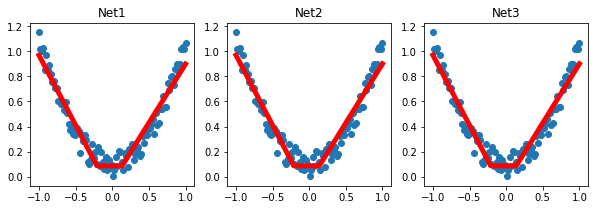

In [24]:
# save net1

save()

# restore entire net
restore_net()

# restore only the net parameters
restore_params()

# Recipe 3-8 : Implementing a convolutional neural network

__Problem__: How do we set up a RNN using the MNIST dataset?

__Solution__: RNNs are used to model image data less frequently than CNNs, but can still learn to model images by   evaluating sequences columns/rows of pixels. 

<a id = 'Recipe-3-3-:-Implementing-a-convolutional-neural-network'></a>

torch.Size([60000, 28, 28])
torch.Size([60000])


c:\users\petersont\appdata\local\continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


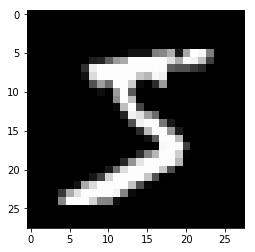

In [61]:
# imports and parameters

from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms

torch.manual_seed(1)

epoch = 1
batch_size = 64
time_set = 28  # rnn time step / image height
input_size = 28  # rnn input size / image width
lr = 0.01
download_mnist = True

train_data = torchvision.datasets.MNIST(
    root="C:\\Users\\petersont\\Desktop\\mnist",
    train=True
    # transform to shape of (color x height x width) and normalize to range [0.0, 1.0]
    ,
    transform=transforms.ToTensor(),
    download=download_mnist,
)

# plot on example

print(train_data.data.size())
print(train_data.targets.size())
plt.imshow(train_data.data[0].numpy(), cmap="gray")

# load the dataset using the loader functionality. the image batch shape with be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=batch_size, shuffle=True
)

# convert test data into Variable, pick 2000 sammples to speed up testing
test_data = dsets.MNIST(
    root="C:\\Users\\petersont\\Desktop\\mnist",
    train=False,
    transform=transforms.ToTensor(),
)
test_x = Variable(test_data.data, volatile=True).type(torch.FloatTensor)[:2000] / 255

# shape from (2000, 28, 28) tp (2000, 1 , 28, 28) with values in range of (0,1)
test_y = test_data.targets.numpy().squeeze()[:2000]

In [62]:
# RNN model. we are training an LSTM network as opposed to a standard RNN model, because LSTM does a better
# job at holding information in memory long-term. the output vector has a size of 64 X 10 because the output
# layer has digits to be classified between 0 and 9. the forward function executes forward propagation


class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(  # as opposed to nn.RNN(), which does not learn well
            input_size=input_size,
            hidden_size=64,  # rnn hidden unit
            num_layers=1,  # number of RNN layers
            batch_first=True,  # input and output will have batch size as 1st dim
        )

        self.out = nn.Linear(64, 10)

    def forward(self, x):
        # x shape = (batch, time_step, input_size)
        # r_out shape = (batch, time_step, output_size)
        # h_n shape  = (n_layers, batch, hidden_size)
        # h_c shape  = (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(
            x, None
        )  # None represents zero initial hidden state

        # choose r_out as the last time step
        out = self.out(r_out[:, -1, :])
        return out

In [63]:
# the input length is 28, the number of neurons in the hidden layer is 64, and the output has 10 neurons

rnn = RNN()
print(rnn)

# set optimization function as Adam and loss function as cross-entropy
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

# training and testing
for epoch in range(epoch):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(
            x.view(-1, 28, 28)
        )  # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)  # batch y

        output = rnn(b_x)  # rnn output
        loss = loss_func(output, b_y)  # cross entropy loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation for computing gradients
        optimizer.step()  # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)  # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print(
                "Step {} | train loss: {} | test accuracy {}".format(
                    step, loss.data.item(), accuracy
                )
            )

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)
Step 0 | train loss: 2.2883260250091553 | test accuracy 0.1025
Step 50 | train loss: 0.8085114359855652 | test accuracy 0.6025
Step 100 | train loss: 0.8934600949287415 | test accuracy 0.7255
Step 150 | train loss: 0.5310683846473694 | test accuracy 0.8435
Step 200 | train loss: 0.27613556385040283 | test accuracy 0.843
Step 250 | train loss: 0.3350260853767395 | test accuracy 0.8675
Step 300 | train loss: 0.28485921025276184 | test accuracy 0.904
Step 350 | train loss: 0.31743693351745605 | test accuracy 0.938
Step 400 | train loss: 0.10681182891130447 | test accuracy 0.933
Step 450 | train loss: 0.27030155062675476 | test accuracy 0.9175
Step 500 | train loss: 0.13088065385818481 | test accuracy 0.9315
Step 550 | train loss: 0.10261544585227966 | test accuracy 0.9405
Step 600 | train loss: 0.10757777839899063 | test accuracy 0.927
Step 650 | train loss: 0.22127607464790344 | tes

In [66]:
#

test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, "prediction number")
print(test_y[:10], "real number")

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


# Recipe 3-9 : Implementing a RNN for regression problems

__Problem__: How do we set up a RNN for regression problems? In this example we want to predict a cosine wave based on an input sin wave.

__Solution__: RNN regression problems require a target function and a feature set, and a function to establish the relationship between the input and output. RNNs in regression problems are generally limited to data that shows a clear linear relationship. Nonlinear implementations are more complex In this example, we will use data that forms a nonlinear cyclical pattern between input and output data. Unlike the MNIST classification RNN, this model will only have one output neuron representing the predicted numeric variable.

<a id = 'Recipe-3-9-:-Implementing-a-RNN-for-regression-problems'></a>

In [67]:
# imports and parameters
from torch import nn
from torch.autograd import Variable

torch.manual_seed(1)

time_step = (
    10
)  # implies that the last 10 values will be used to predict the current value
input_size = 1
lr = 0.02

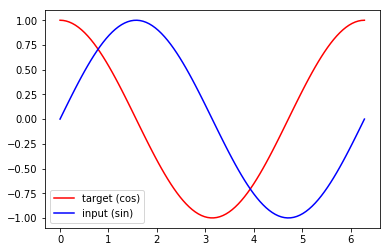

In [68]:
# create and plot sample data
steps = np.linspace(0, np.pi * 2, 100, dtype=np.float32)
x_np = np.sin(steps)
y_np = np.cos(steps)
plt.plot(steps, y_np, "r-", label="target (cos)")
plt.plot(steps, x_np, "b-", label="input (sin)")
plt.legend(loc="best")
plt.show()

In [73]:
# create RNN model
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=32,
            num_layers=1,
            batch_first=True,  # 1st dimension is batch size
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h_state):
        r_out, h_state = self.rnn(x, h_state)
        outs = []  # save all predictions
        for time_step in range(r_out.size(1)):
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


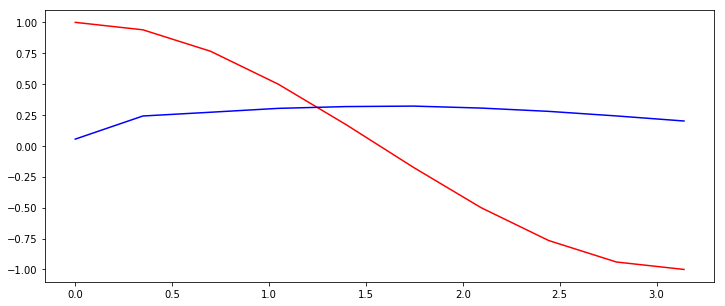

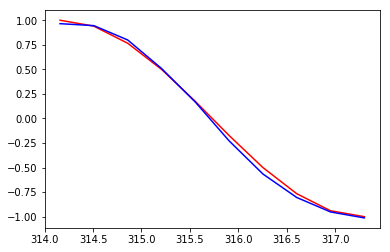

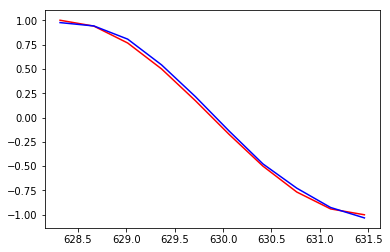

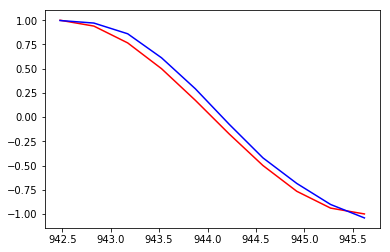

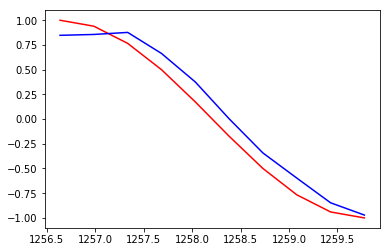

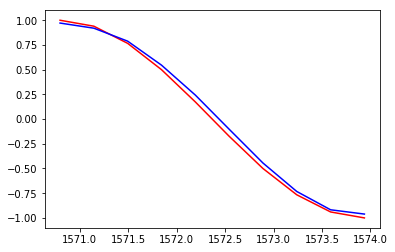

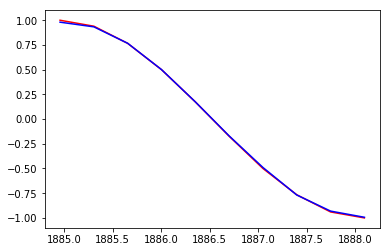

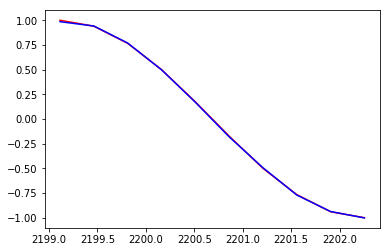

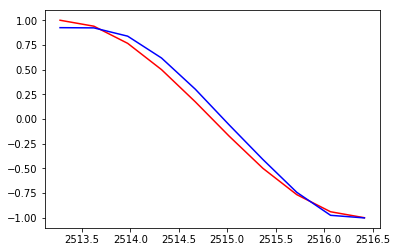

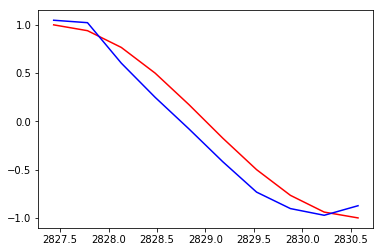

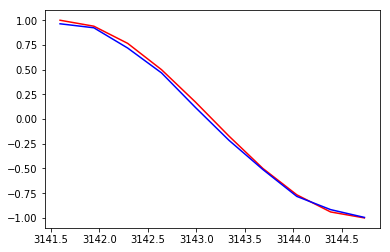

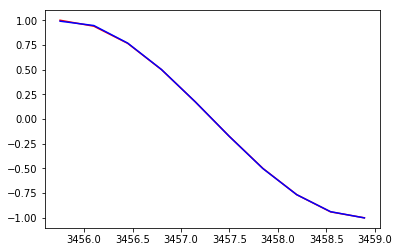

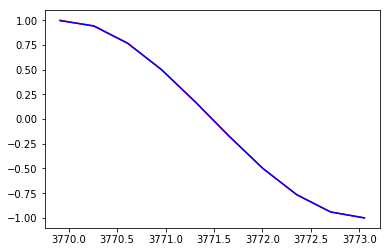

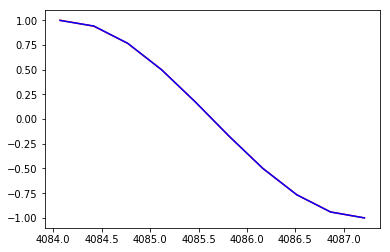

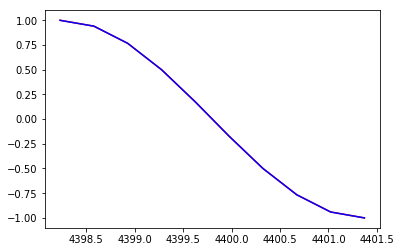

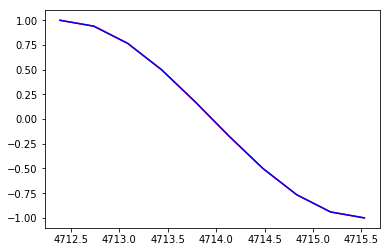

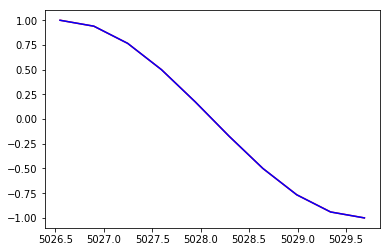

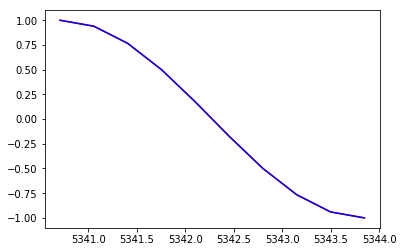

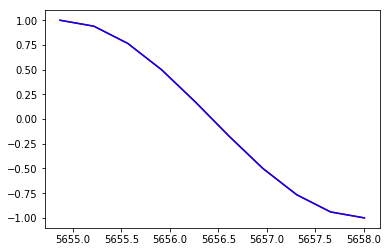

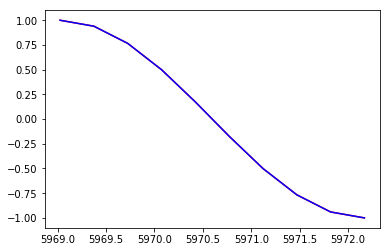

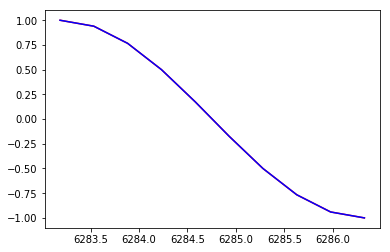

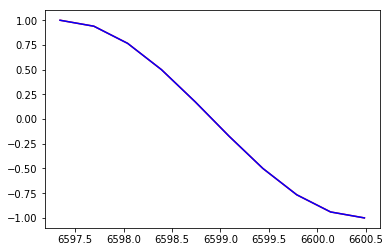

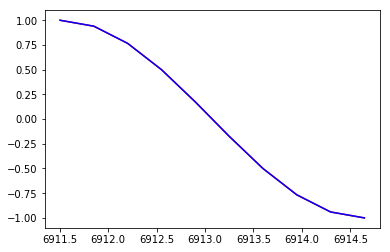

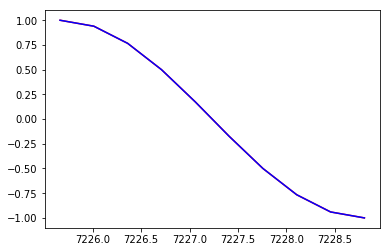

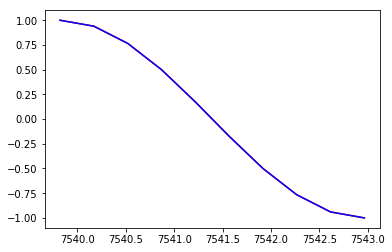

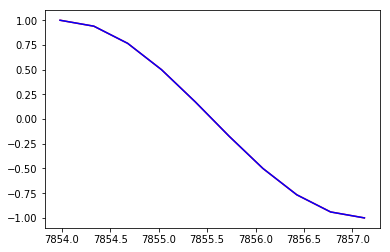

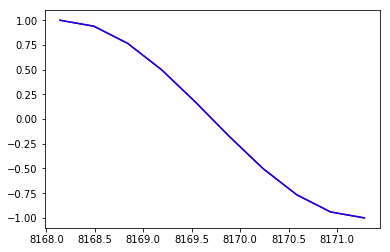

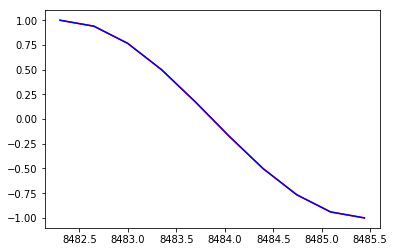

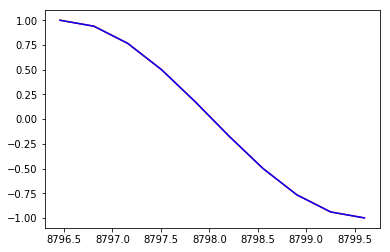

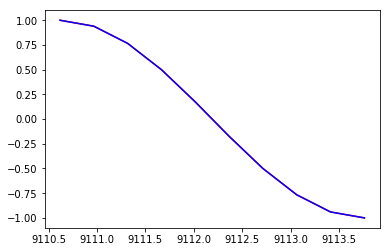

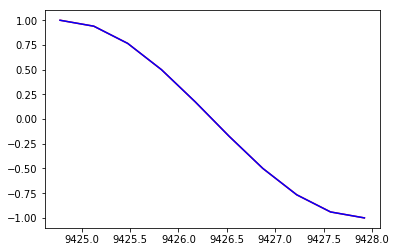

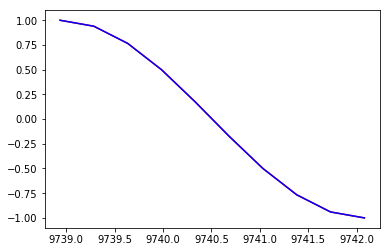

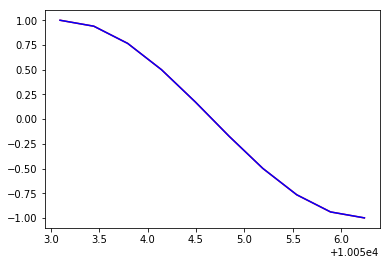

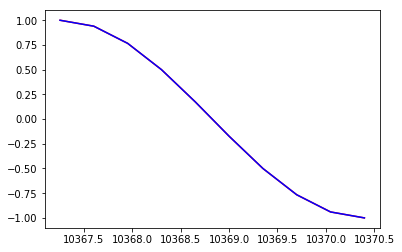

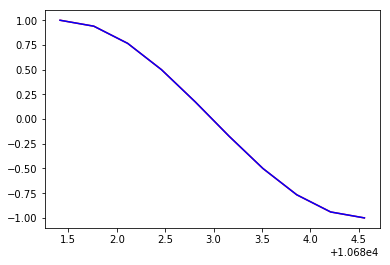

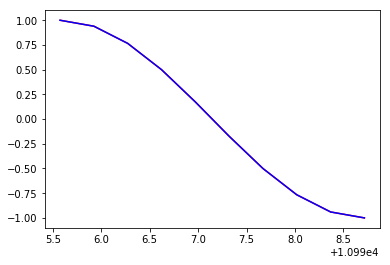

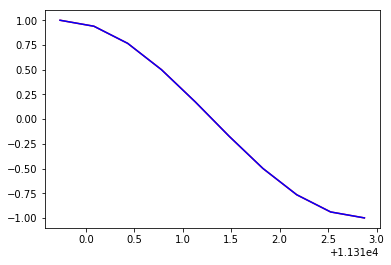

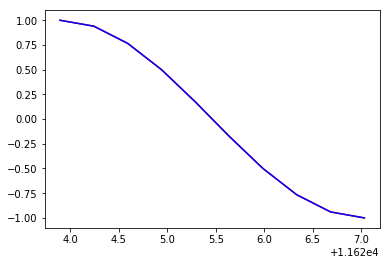

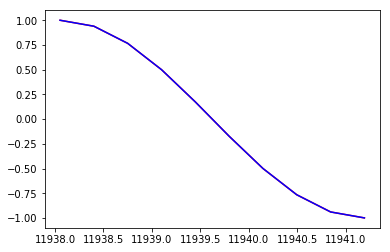

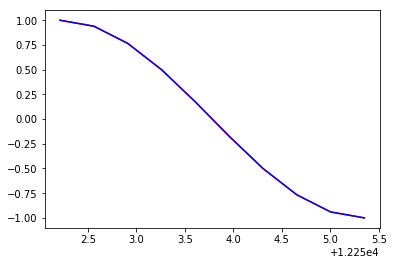

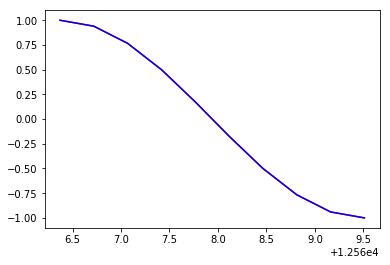

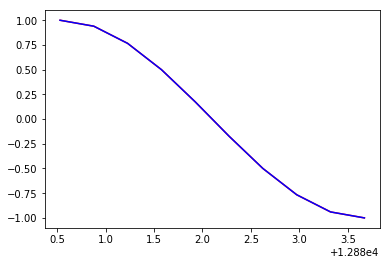

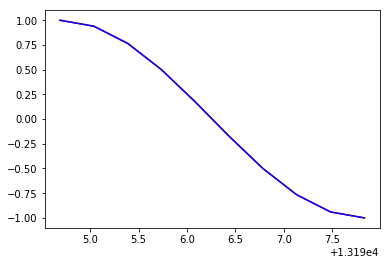

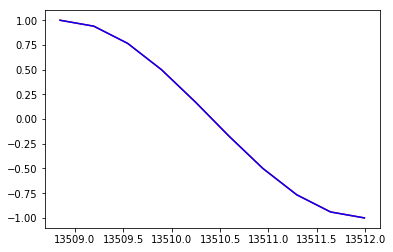

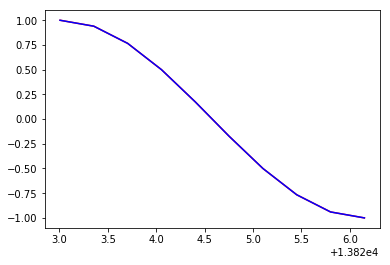

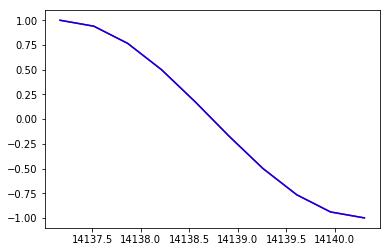

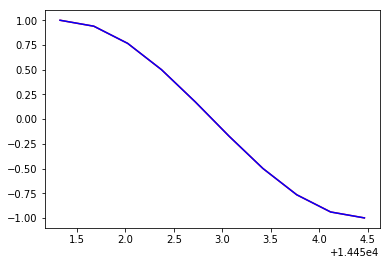

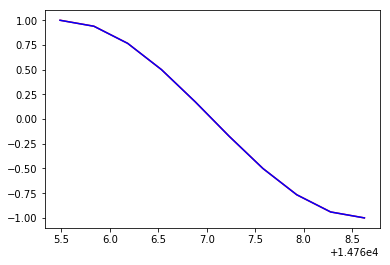

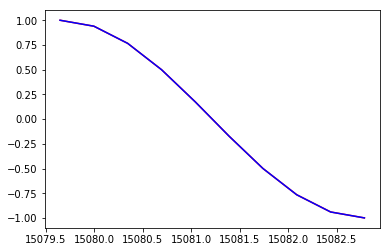

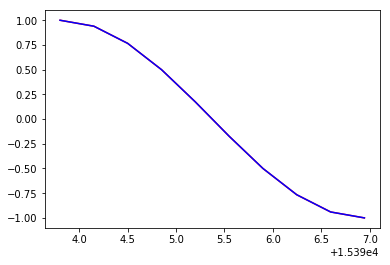

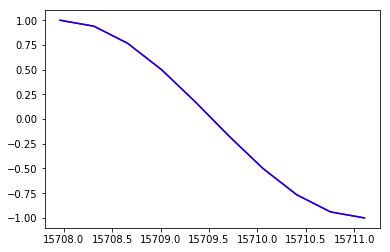

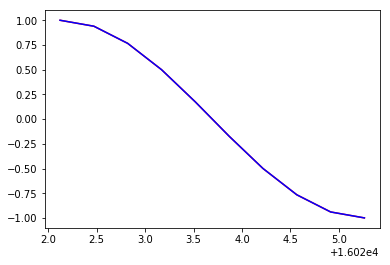

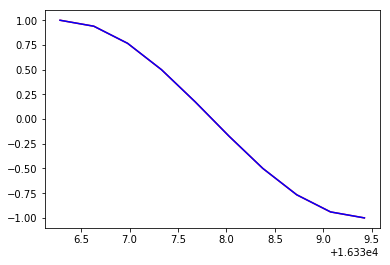

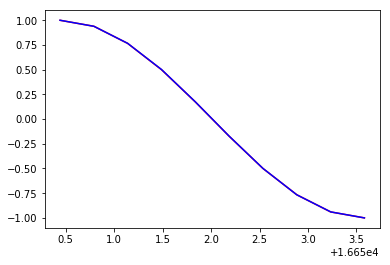

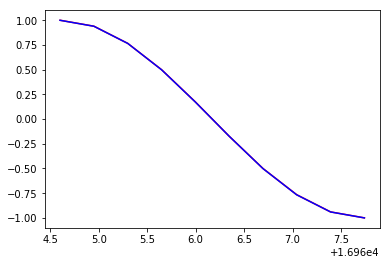

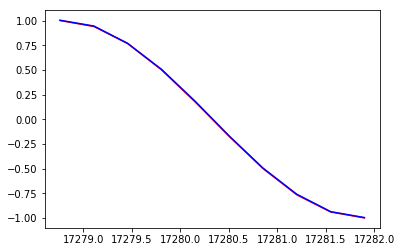

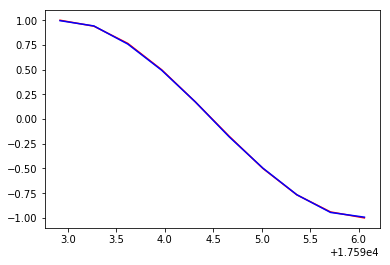

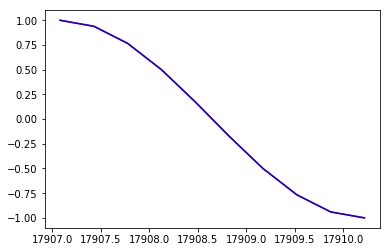

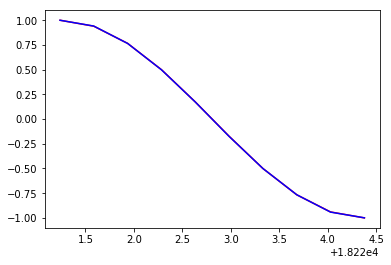

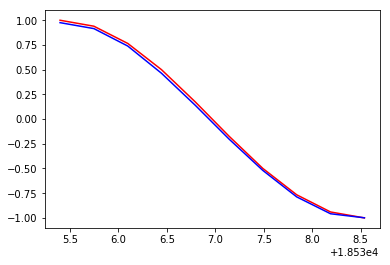

In [76]:
# train RNN
rnn = RNN()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
loss_func = nn.MSELoss()
h_state = None

plt.figure(1, figsize=(12, 5))
plt.ion()  # numericly plot

for step in range(6000):
    start, end = step * np.pi, (step + 1) * np.pi  # time range
    steps = np.linspace(start, end, time_step, dtype=np.float32)
    x_np = np.sin(steps)
    y_np = np.cos(steps)

    x = Variable(
        torch.from_numpy(x_np[np.newaxis, :, np.newaxis])
    )  # shape = (batch, time_step, input_size)
    y = Variable(torch.from_numpy(y_np[np.newaxis, :, np.newaxis]))

    prediction, h_state = rnn(x, h_state)  # rnn output
    h_state = Variable(h_state.data)

    loss = loss_func(prediction, y)  # MSE
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # plotting
    if step % 100 == 0:
        plt.plot(steps, y_np.flatten(), "r-")
        plt.plot(steps, prediction.data.numpy().flatten(), "b-")
        plt.draw
        plt.pause(0.05)

# Recipe 3-10 : Working with autoencoders

__Problem__: How do we perform clustering using the autoencoders function?

__Solution__: Autoencoders transform the input feature space into a lower dimensional tensor representation using a hidden layer and mapped back to the same dimensionality that was initially input. Autoencoders identify latent features from the dataset and can be used in classifcation, prediction and clustering tasks. Conceptually, this process can be thought of as forming an input layer and output layer with the initial dataset, and then multiple hidden layers are added in between the input and output layers. The weights in the central hidden layer form what is referred to as the autoencoder layer

<a id = 'Recipe-3-10-:-Working-with-autoencoders'></a>

torch.Size([60000, 28, 28])
torch.Size([60000])


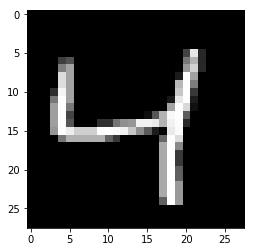

In [117]:
# imports and parameters
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

%matplotlib inline

torch.manual_seed(1)
epochs = 10
batch_size = 64
lr = 0.005
download_mnist = False
n_test_img = 5  # number of test images

train_data = torchvision.datasets.MNIST(
    root="C:\\Users\\petersont\\Desktop\\mnist",
    train=True
    # transform to shape of (color x height x width) and normalize to range [0.0, 1.0]
    ,
    transform=torchvision.transforms.ToTensor(),
    download=download_mnist,
)

# plot one example
print(train_data.data.size())
print(train_data.targets.size())
plt.imshow(train_data.data[2].numpy(), cmap="gray")

train_loader = Data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

In [118]:
# the input has 784 features, with a height of 28 and a width of 28. we pass the 784 neurons from the input
# layer to the first hidden layer, which has 128 neurons in it. then we apply the hyperbolic tangent function
# to pass the information to the next hidden layer. the second hidden layer contains 128 input neurons and
# transforms it into 64 neurons. we again apply the hyperbolic tangent activation function before pass
# the information to the next hidden layer. the inner most layer contains 3 neurons, which are considered
# to be 3 features, and this marks the end of the encoder layer. The decoder function expands the center
# layer back to 784 features
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3),  # compress to 3 features
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),  # compress to a range of (0,1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [119]:
# setup autoencoder, optimizer and loss function
autoencoder = AutoEncoder()
print(autoencoder)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
loss_func = nn.MSELoss()

# original first row in the data
view_data = Variable(
    train_data.data[:n_test_img].view(-1, 28 * 28).type(torch.FloatTensor) / 255.0
)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


Epoch: 0 | Step: 0 | train loss: 0.23332487046718597


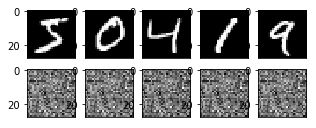

Epoch: 0 | Step: 500 | train loss: 0.06102956086397171


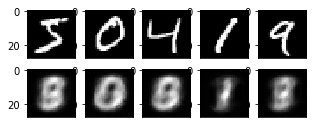

Epoch: 5 | Step: 0 | train loss: 0.036575797945261


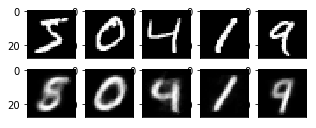

Epoch: 5 | Step: 500 | train loss: 0.03915543854236603


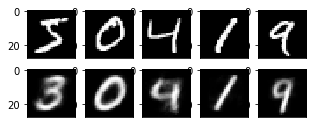

Epoch: 9 | Step: 0 | train loss: 0.03827313706278801


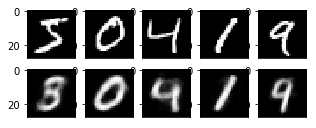

Epoch: 9 | Step: 500 | train loss: 0.03695761039853096


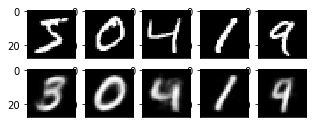

In [120]:
# run workflow
for epoch in range(epochs):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x.view(-1, 28 * 28))
        b_y = Variable(x.view(-1, 28 * 28))
        b_label = Variable(y)

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 500 == 0 and epoch in [0, 5, epochs - 1]:
            print(
                "Epoch: {} | Step: {} | train loss: {}".format(
                    epoch, step, loss.data.item()
                )
            )

            # plot decoded image
            _, decoded_data = autoencoder(view_data)

            # initialize figure
            f, a = plt.subplots(2, n_test_img, figsize=(5, 2))

            for i in range(n_test_img):
                a[0][i].imshow(
                    np.reshape(view_data.data.numpy()[i], (28, 28)), cmap="gray"
                )
                a[0][i].set_xticks(())
                a[0][i].set_xticks(())
            for i in range(n_test_img):
                a[1][i].clear()
                a[1][i].imshow(
                    np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap="gray"
                )
                a[1][i].set_xticks(())
                a[1][i].set_xticks(())
            plt.show()

what is FloatTensor divided by? check code on packt


(-2.4268296, 2.1778057)

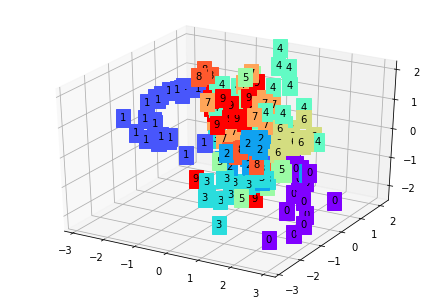

In [124]:
# visualize the encoded data. we have 3 neurons in the central layer of the AutoEncoder, so this will be a 3D plot.
view_data = Variable(
    train_data.data[:200].view(-1, 28 * 28).type(torch.FloatTensor) / 255.0
)
encoded_data, _ = autoencoder(view_data)

fig = plt.figure(2)
ax = Axes3D(fig)

X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy()

values = train_data.targets[:200].numpy()
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255 * s / 9))
    ax.text(x, y, z, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())

# Recipe 3-11 : Restricting model overfitting

__Problem__: When fitting many neurons and layers to predict and output, the model may overfit the training data, and as a consequence perform poorly on unseen data.

__Solution__: To restrict model overfitting, we introduce a dropout function, which means we suppress/delete a set percentage of the weights in the network

<a id = 'Recipe-3-11-:-Restricting-model-overfitting'></a>

In [105]:
# import and parameters
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt

%matplotlib inline

torch.manual_seed(1)
n_samples = 20
n_hidden = 300

In [106]:
# train and test data
x = torch.unsqueeze(torch.linspace(-1, 1, n_samples), 1)
y = x + 0.3 * torch.normal(torch.zeros(n_samples, 1), torch.ones(n_samples, 1))
x = Variable(x)
y = Variable(y)

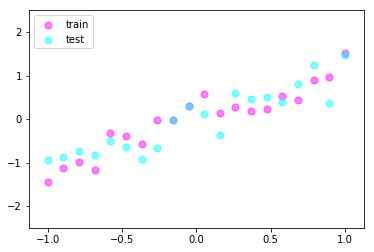

In [107]:
# train and test data
with torch.no_grad():
    test_x = torch.unsqueeze(torch.linspace(-1, 1, n_samples), 1)
    test_y = test_x + 0.3 * torch.normal(
        torch.zeros(n_samples, 1), torch.ones(n_samples, 1)
    )

    test_x = Variable(test_x)
    test_y = Variable(test_y)

# plot data
plt.scatter(x.data.numpy(), y.data.numpy(), c="magenta", s=50, alpha=0.5, label="train")
plt.scatter(
    test_x.data.numpy(), test_y.data.numpy(), c="cyan", s=50, alpha=0.5, label="test"
)
plt.legend(loc="upper left")
plt.ylim((-2.5, 2.5))
plt.show()

In [108]:
# create intentionally overfit model for illustrative purposes
net_overfitting = torch.nn.Sequential(
    torch.nn.Linear(1, n_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(n_hidden, n_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(n_hidden, 1),
)

In [109]:
# introducing a dropout rate to the hidden layer removes a defined percentage of weights / connections from the architecture. a typical
# percentage is between 20% and 505%. Smaller percentages imply a smaller degree of penalization. in this example, a 50% dropout rate is applied
net_dropped = torch.nn.Sequential(
    torch.nn.Linear(1, n_hidden),
    torch.nn.Dropout(0.5),  # drop 50% of the neurons
    torch.nn.ReLU(),
    torch.nn.Linear(n_hidden, n_hidden),
    torch.nn.Dropout(0.5),  # drop 50% of the neurons
    torch.nn.ReLU(),
    torch.nn.Linear(n_hidden, 1),
)

In [110]:
# print models
print(net_overfitting)
print(net_dropped)

Sequential(
  (0): Linear(in_features=1, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=1, bias=True)
)
Sequential(
  (0): Linear(in_features=1, out_features=300, bias=True)
  (1): Dropout(p=0.5)
  (2): ReLU()
  (3): Linear(in_features=300, out_features=300, bias=True)
  (4): Dropout(p=0.5)
  (5): ReLU()
  (6): Linear(in_features=300, out_features=1, bias=True)
)


In [111]:
# setup optimizers and loss function
optimizer_ofit = torch.optim.Adam(net_overfitting.parameters(), lr=0.01)
optimizer_drop = torch.optim.Adam(net_dropped.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

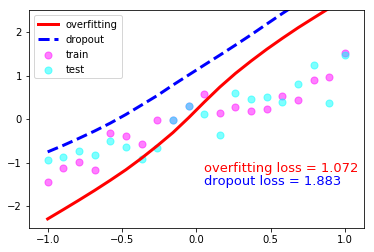

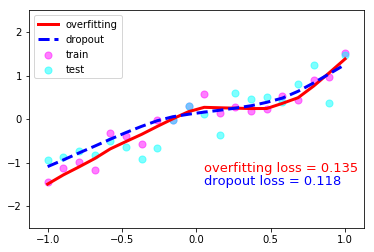

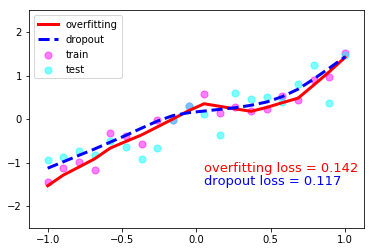

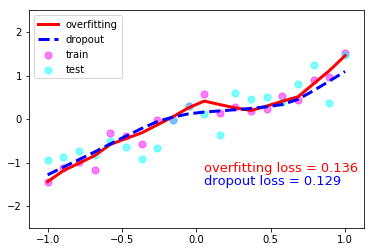

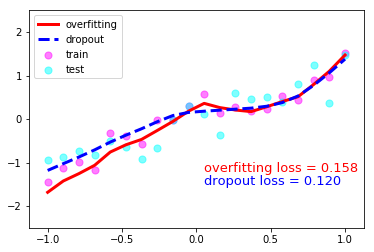

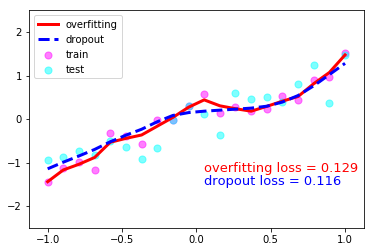

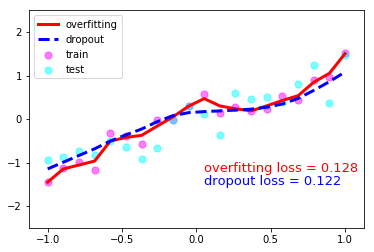

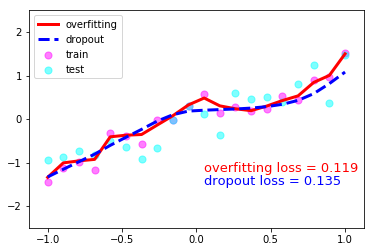

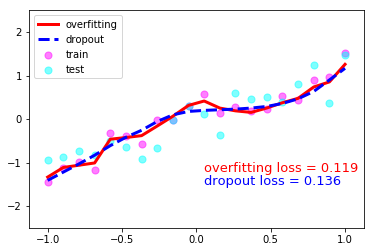

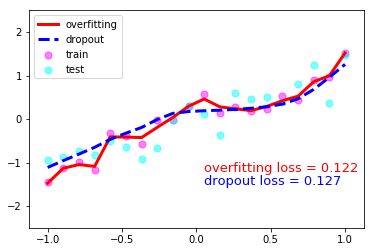

In [112]:
# visualize the extent of overfitting by iteratively changing the model hyperparameters and visualizing the results. here, we generate predictions from
# both the base model and the dropout model. we create two loss functions, two backpropagation process and two implementations of optimization
for t in range(500):
    pred_ofit = net_overfitting(x)
    pred_drop = net_dropped(x)
    loss_ofit = loss_func(pred_ofit, y)
    loss_drop = loss_func(pred_drop, y)

    optimizer_ofit.zero_grad()
    optimizer_drop.zero_grad()
    loss_ofit.backward()
    loss_drop.backward()
    optimizer_ofit.step()
    optimizer_drop.step()

    if t % 50 == 0:
        # change to eval mode in order to fix dropout effecyt
        net_overfitting.eval()
        net_dropped.eval()

        # plot
        test_pred_ofit = net_overfitting(test_x)
        test_pred_drop = net_dropped(test_x)
        plt.scatter(
            x.data.numpy(), y.data.numpy(), c="magenta", s=50, alpha=0.5, label="train"
        )
        plt.scatter(
            test_x.data.numpy(),
            test_y.data.numpy(),
            c="cyan",
            s=50,
            alpha=0.5,
            label="test",
        )
        plt.plot(
            test_x.detach().numpy(),
            test_pred_ofit.detach().numpy(),
            "r-",
            lw=3,
            label="overfitting",
        )
        plt.plot(
            test_x.detach().numpy(),
            test_pred_drop.detach().numpy(),
            "b--",
            lw=3,
            label="dropout",
        )

        plt.text(
            0.05,
            -1.2,
            "overfitting loss = {:.3f}".format(
                loss_func(test_pred_ofit, test_y).data.item()
            ),
            fontdict={"size": 13, "color": "red"},
        )
        plt.text(
            0.05,
            -1.5,
            "dropout loss = {:.3f}".format(
                loss_func(test_pred_drop, test_y).data.item()
            ),
            fontdict={"size": 13, "color": "blue"},
        )
        plt.legend(loc="upper left")
        plt.ylim((-2.5, 2.5))
        plt.pause(0.1)

        # switch back to training mode
        net_overfitting.train()
        net_dropped.train()
        plt.show()

# Recipe 3-12 : Initializing weights in the dropout rate

__Problem__: How do we delete the weight in a netowkr? Should we delete randomly or by using a particular distribution?

__Solution__: We should delete the weights in the dropout layer based on a probability distribution, rather than randomly. The following script demonstrates how to generate the weights from a uniform distribution.

<a id = 'Recipe-3-12-:-Initializing-weights-in-the-dropout-rate'></a>

In [126]:
# imports
from __future__ import print_function
import numpy as np
import torch

In [132]:
# create 5x3 tensor of zeros
torch.Tensor(5, 3)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.8441e-42, 0.0000e+00],
        [0.0000e+00, 2.6838e-41, 0.0000e+00]])

In [133]:
# create 5x3 tensor drawn from uniform distribution
x = torch.Tensor(5, 3).uniform_(-1, 1)
print(x)
print(x.size())

tensor([[ 9.7896e-01, -9.3365e-04,  7.1972e-01],
        [ 3.9731e-01, -6.0787e-01,  2.2546e-01],
        [ 7.4231e-01,  9.5788e-01, -5.0759e-01],
        [-8.0307e-01,  3.4372e-02,  7.8025e-01],
        [ 6.0432e-01,  8.2355e-01, -6.2647e-01]])
torch.Size([5, 3])


In [134]:
# creation from lists and numpy
z = torch.LongTensor([[1, 3], [2, 9]])
print(z.type())

# cast to numpy ndarray
print(z.numpy().dtype)

torch.LongTensor
int64


In [135]:
# data type inferred from numpy
print(torch.from_numpy(np.random.rand(5, 3)).type())
print(torch.from_numpy(np.random.rand(5, 3).astype(np.float32)).type())

torch.DoubleTensor
torch.FloatTensor


In [136]:
# simple mathematical operations
y = x * torch.randn(5, 3)
print(y)

tensor([[-1.4062e+00,  5.4680e-04,  1.2100e+00],
        [ 5.2777e-02, -3.5671e-01,  6.9437e-02],
        [ 5.2341e-02,  8.2363e-02,  2.6015e-01],
        [ 4.7895e-01,  4.9518e-02,  1.4260e+00],
        [ 7.7025e-01, -1.8897e+00,  9.6150e-01]])


In [137]:
# simple mathematical operations
y = x / torch.sqrt(torch.randn(5, 3) ** 2)
print(y)

tensor([[ 1.2423e+00, -4.8357e-04,  1.6711e+00],
        [ 1.0919e+00, -9.6629e-01,  2.5834e+00],
        [ 3.6808e-01,  7.7314e+00, -1.9145e+00],
        [-1.1064e+00,  2.4755e-02,  8.6714e-01],
        [ 1.5275e+00,  4.5736e+00, -1.8533e+00]])


In [138]:
# broadcasting
print(x.size())
y = x + torch.randn(5, 1)
print(y)

torch.Size([5, 3])
tensor([[-0.7605, -1.7404, -1.0197],
        [-1.3322, -2.3374, -1.5041],
        [ 1.0178,  1.2334, -0.2321],
        [-2.5380, -1.7006, -0.9547],
        [-0.4066, -0.1873, -1.6374]])


In [143]:
# reshape
y = torch.randn(5, 10, 15)
print(y.size())
print(y.view(-1, 15).size())  # same as doing y.view(50,15).size()
print(y.view(-1, 15).unsqueeze(1).size())  # adds a dimension at index 1
print(y.view(-1, 15).unsqueeze(1).squeeze().size())
print()
print(y.transpose(0, 1).size())
print(y.transpose(1, 2).size())
print(y.transpose(0, 1).transpose(1, 2).size())
print(y.permute(1, 2, 0).size())

torch.Size([5, 10, 15])
torch.Size([50, 15])
torch.Size([50, 1, 15])
torch.Size([50, 15])

torch.Size([10, 5, 15])
torch.Size([5, 15, 10])
torch.Size([10, 15, 5])
torch.Size([10, 15, 5])


In [144]:
# repeat
print(y.view(-1, 15).unsqueeze(1).expand(50, 100, 15).size())
print(y.view(-1, 15).unsqueeze(1).expand_as(torch.randn(50, 100, 15)).size())

torch.Size([50, 100, 15])
torch.Size([50, 100, 15])


In [145]:
# concateanate
print(torch.cat([y, y], 2).size())  # concat on dimension 2
print(torch.stack([y, y], 0).size())  # stack along new dimension

torch.Size([5, 10, 30])
torch.Size([2, 5, 10, 15])


In [147]:
# batch normalization using a 2D layer before entering a 2D max pooling layer
x = Variable(torch.randn(10, 3, 28, 28))
conv = nn.Conv2d(
    in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1, padding=1, bias=True
)
bn = nn.BatchNorm2d(num_features=32)
pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

output_conv = bn(conv(x))
output_pool = pool(conv(x))

print("Conv output size: {}".format(output_conv.size()))
print("Pool output size: {}".format(output_pool.size()))

Conv output size: torch.Size([10, 32, 28, 28])
Pool output size: torch.Size([10, 32, 14, 14])


# Recipe 3-13 : Embedding layers in RNN

__Problem__: RNNs are frequently used for text processing. An embedded feature offers more accuracy than a raw feature. How do we create embedded features in an RNN?

__Solution__: An embedding layer is a fixed-size dictionary with a fixed-size lookup table. In the context of summarizing text vocabularies, it offers an alternative approach to the bag-of-words model. 

<a id = 'Recipe-3-13-:-Embedding-layers-in-RNN'></a>

In [149]:
# recurrent, embedding and dropout layers
inputs = [[1, 2, 3], [1, 0, 4], [1, 2, 4], [1, 4, 0], [1, 3, 3]]
x = Variable(torch.LongTensor(inputs))

embedding = nn.Embedding(num_embeddings=5, embedding_dim=20, padding_idx=1)
drop = nn.Dropout(p=0.5)
gru = nn.GRU(
    input_size=20,
    hidden_size=50,
    num_layers=2,
    batch_first=True,
    bidirectional=True,
    dropout=0.3,
)

emb = drop(embedding(x))
gru_h, gru_h_t = gru(emb)

print("embedding size : {}".format(emb.size()))
print("GRU hidden states size : {}".format(gru_h.size()))
print("GRU last hidden state size : {}".format(gru_h_t.size()))

embedding size : torch.Size([5, 3, 20])
GRU hidden states size : torch.Size([5, 3, 100])
GRU last hidden state size : torch.Size([4, 5, 50])


In [152]:
# leverage the functional API to use these classes in a functional way
import torch.nn.functional as F

x = Variable(torch.randn(10, 3, 28, 28))
filters = Variable(torch.randn(32, 3, 3, 3))
conv_out = F.relu(
    F.dropout(F.conv2d(input=x, weight=filters, padding=1), p=0.5, training=True)
)
print("Conv output size : {}".format(conv_out.size()))

Conv output size : torch.Size([10, 32, 28, 28])
